In [1]:
%%capture
%pip install numpy matplotlib pandas seaborn scipy

In [2]:
from scipy.signal import butter, lfilter, find_peaks
from scipy.fft import fft, fftfreq
import numpy as np
import scipy.signal as ss
from matplotlib import pyplot as plt

In [3]:
with open('dados_ecg.txt', 'r') as file:
    data = file.readlines()

# Converte os dados para um array numpy
ecg_data = np.fromstring(''.join(data), dtype=float, sep='\n')

A frequência de amostragem do Arduino Uno depende da velocidade com que os dados do ADC são lidos (conversor analógico-digital). O ADC do Arduino Uno tem uma taxa de amostragem de 9.6 kHz (9.600 amostras por segundo), mas a velocidade com que você lê os dados do ADC pode ser menor do que isso.

Por exemplo, se você ler os dados do ADC a cada 10 milissegundos (0,01 segundos), a frequência de amostragem será de 100 Hz (100 amostras por segundo). Se você ler os dados a cada 1 milissegundo (0,001 segundos), a frequência de amostragem será de 1 kHz (1.000 amostras por segundo).

No nosso caso, não colocamos nenhum tempo entre a leitura dos dados do ADC, então a frequência de amostragem será de 9.6 kHz (9.600 amostras por segundo).

In [10]:
fs = 9600


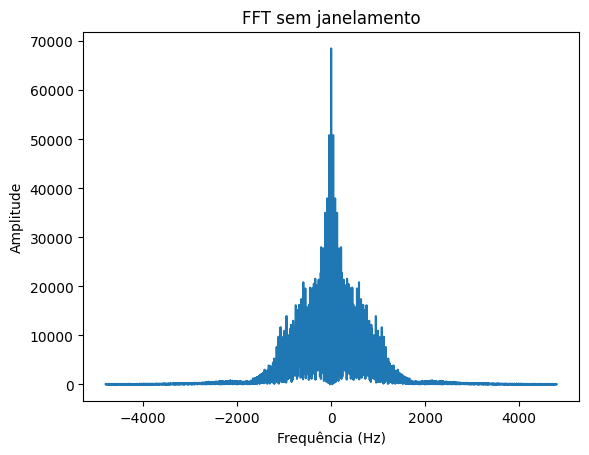

In [11]:
# Aplica a transformada de Fourier
fft_signal = np.fft.fft(ecg_data)
# Normalizando a FFT
fft_signal = np.abs(fft_signal)
# Deslocando a FFT para o centro
fft_signal = np.fft.fftshift(fft_signal)
# Criando o eixo da frequência
freq = np.arange(0,fs,fs/fft_signal.shape[0])-fs/2
# Plotando o gráfico
plt.plot(freq,fft_signal)
plt.title('FFT sem janelamento')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.show()

In [12]:
lowcut = 0.5
highcut = 100
order = 200  # Ordem do filtro
order2 = 250
# Removendo 60Hz com rejeita-faixa
b, a = butter(order2, [58, 62], btype='bandstop', fs=fs)
filtered_ecg = lfilter(b, a, ecg_data)



In [13]:
filtered_ecg

array([ 0.,  0.,  0., ..., nan, nan, nan])

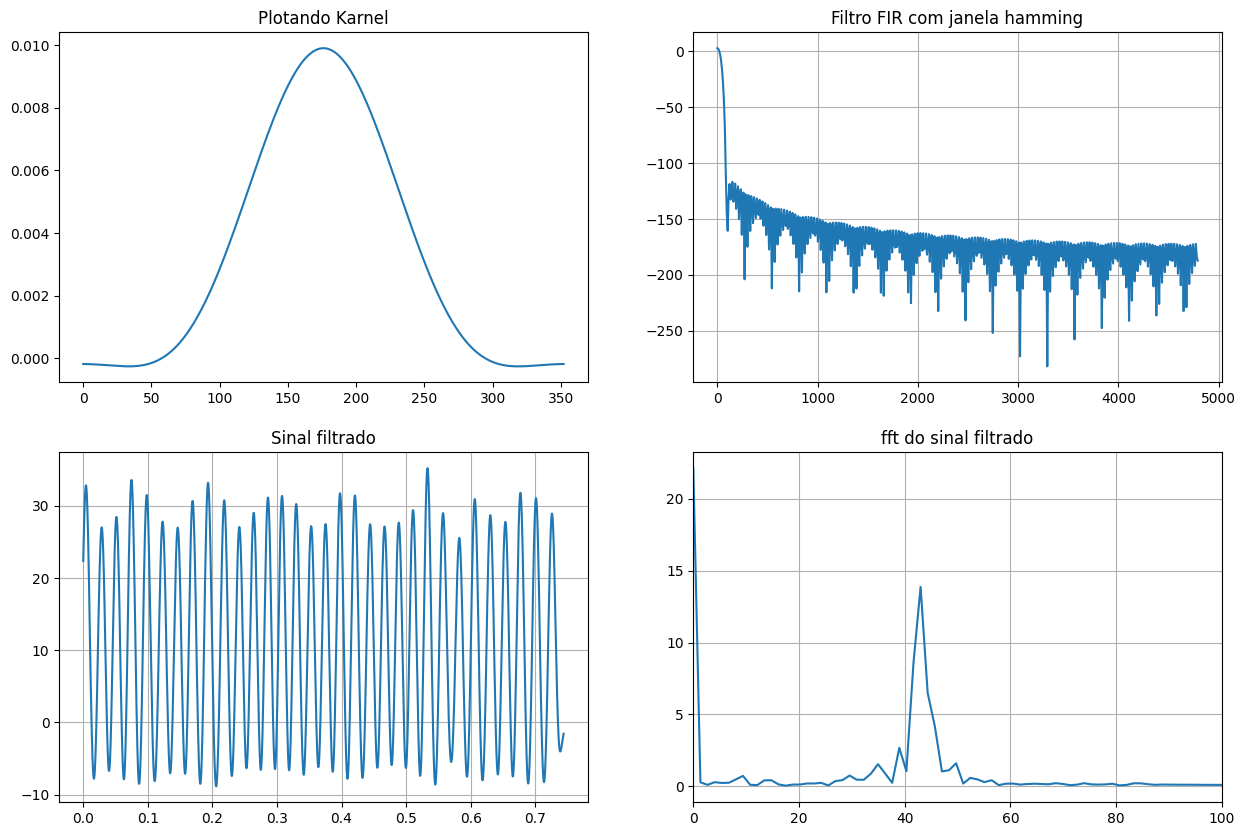

In [14]:
sinal = ecg_data
order = 353
order2 = 353
lista_passa_alta = [0.5, 40]
lista_rejeita_faixa = [
    0.5, 1,
    5, 20,
    ]

# Calculando o Karnel
h_fir1 = ss.firwin(order, lista_passa_alta, window='hamming', fs=fs, pass_zero='bandpass')
h_fir2 = ss.firwin(order, lista_rejeita_faixa, window='hamming', fs=fs, pass_zero='bandstop')

# Calculando a FFT do karnel
freq_fir1, abss_fir1 = ss.freqz(h_fir1,fs=fs)
Db_fir1 = 20*np.log(abs(abss_fir1))
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(h_fir1)
plt.title('Plotando Karnel')
plt.subplot(222)
plt.plot(freq_fir1,Db_fir1)
plt.title('Filtro FIR com janela hamming')
plt.grid('on')

# Aplicando o filtro
filtered_fir1 = np.convolve(h_fir1, sinal, mode='same')
filtered_fir2 = np.convolve(h_fir2, filtered_fir1, mode='same')

t = np.arange(filtered_fir1.size) / fs
plt.subplot(223)
plt.plot(t, filtered_fir2)
plt.title('Sinal filtrado')
plt.grid('on')

# Calculando a FFT do sinal filtrado
filteredfft_fir1 = abs(2*np.fft.fft(filtered_fir2) / filtered_fir2.shape[0])
freq_fir1 = np.linspace(0, fs - 1 / fs, filteredfft_fir1.shape[0])
plt.subplot(224)
plt.plot(freq_fir1, filteredfft_fir1)
plt.title('fft do sinal filtrado')
plt.xlim([0, 100])
plt.grid('on')

In [16]:
# Encontra os picos no sinal filtrado
peaks, _ = find_peaks(filtered_fir2)

In [23]:
# Frequencia cardíaca
fc = 60
# Calcula o tempo entre os picos
time_between_peaks = np.diff(peaks) / fs
# Calcula a frequencia cardíaca
fc = 1 / time_between_peaks
# Calcula a frequencia cardíaca média
fc_mean = np.mean(fc)


In [25]:
print(f'Frequência cardíaca média: {fc_mean:.2f} bpm')

Frequência cardíaca média: 43.02 bpm
